# Reprise brief emotion (brief 8)

In [1]:
# import
import pandas as pds
#import string
import numpy as np

#for machine Learning - classification 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
#
# for visuaiization
#import seaborn as sns
import matplotlib.pyplot as plt

#for NLP
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import nltk # A supprimer si OK

In [2]:
# Lecture du fichiern et création de la data frame.
#  Nom des colonnes: tweet_id, sentiment, author, content
#  Liste des sentiments : 'empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
#    'hate' 'happiness' 'boredom' 'relief' 'anger'

data_emo2= pds.read_csv('./datas/text_emotion.csv')
#data_emo2= pds.read_csv('./datas/text_emotion_02.csv')
#, engine= "python", encoding='utf-8', error_bad_lines=False) # POUR GOOGLE COLAB SINON ERREUR!

print("Nombre de message:",len(data_emo2))

df_count_emotion = data_emo2.groupby(['sentiment']).size().reset_index(name='compt')
print("Les émotions....:\n",df_count_emotion)

df_count_author = data_emo2.groupby(['author']).size().reset_index(name='compt')
#print(df_count_author)
print("Les auteurs par ordres décroissant du nombre de message postés:\n",
      df_count_author.sort_values(by= "compt", ascending = False).head(30))


Nombre de message: 40000
Les émotions....:
      sentiment  compt
0        anger    110
1      boredom    179
2        empty    827
3   enthusiasm    759
4          fun   1776
5    happiness   5209
6         hate   1323
7         love   3842
8      neutral   8638
9       relief   1526
10     sadness   5165
11    surprise   2187
12       worry   8459
Les auteurs par ordres décroissant du nombre de message postés:
                 author  compt
7942       MissxMarisa     23
2171      ChineseLearn     22
7668    MiDesfileNegro     19
18330       erkagarcia     19
24210         lost_dog     18
32187         tsarnick     17
6093        KimmiMcfly     15
23944      linnetwoods     15
3079           Dogbook     14
15739      cece_newnew     14
26091  mrs_mcsupergirl     14
32248       twebbstack     14
9312             Quimo     14
21495  jesssicababesss     13
17396    divxdownloads     13
24184     lopezwilfred     12
11650     TraceyHewins     12
23713        lesley007     12
11577        

## **1) Récupération des données**  
Ce fichier contient 4 colonnes: **tweet_id**, **sentiment**, **author**, **content**. Les émotions associées aux messages (colonne content) sont:  
**anger** (110 messages), **boredom** (179 messages), **empty** (827 messages), **enthusiasm** (759 messages), **fun** (1776  messages), **happiness** (5209 messages), **hate** (1323 messages), **love** (3842 messages), **neutral** (8638 messages), **relief** (1526 messages), **sadness** (5165 messages), **surprise** (2187  messages) et **worry** (8459  messages).  
Nombre de messages: 40 000  
  
En ce qui concerne le texte brut, on voit qu'il sera nécessaire de faire un pré-traitement à l'aide de regex (que je n'ai pu faire, faute de temps). Les @toto indiquants la personne à qui s'adresse le message, les abréviations, les différentes écriture du même mots, les émoticones (complexes car nombreux et avec de nombreuse "orthographe" possible devront impérativement être traité pour espérer aboutir a des résultats correctes.  
  
Les n-grams devront être rechercher et leur pertinance analysée (exemple: lady gaga).  
  
La sous représentation de certains sentiments ne permettentront pas une grande précision (même problème que sur le 1er jeux de donnée).  
  
Il faudrai aussi renomer quelques sentiments pour avoir la même étiquette (happy et happyness).

data_emo2.content.head(20)

## **2) Pré-traitement des données**

### **a) Tokenisation**  
Bien que cette opération soit incluse dans la vectorisation et est donc inutile à ce stade, elle est réalisée à titre d'exercice. Elle pourrait aussi servir pour faciliter un pré traitement des donnéees (pour repérer plus facilement les émoticones par exemple et les ré-associé comme 1 seul mots. les émoticones suivant :), :-), =], :D serait remplacé par le mot sourire ou laissé tel quel).  
  
On crée aussi une nouvelle colonne que l'on rajoute à la data frame de départ contenant le texte "tokénisé".

In [3]:
# Tokenisation

# Création d'une colonne tokenisée
corpus=[]
for el in data_emo2.content:
    token= word_tokenize(el)
    corpus.append(token)
data_emo2['token_brut'] = pds.Series(corpus)
#print(data_emo2.token_brut.head(10))

In [4]:
# Création d'une colonne tokenisée sans stopwords avec ponctuation (important pour les émoticones)
stopwords=nltk.corpus.stopwords.words('english')
#stopwords.extend(exclude)

corpus=[]
for el in data_emo2.token_brut:
    token=[]
    for wd in el:
        if wd not in stopwords:
            token.append(wd)
    corpus.append(token)
data_emo2['token_sans_stopwd'] = pds.Series(corpus)

#data_emo2.token_sans_stopwd.head(10)

In [5]:
# À partir de la cellule précédente on ré-écrit les phrase sans stopword (utilisé par la suite 
#  avec la vectorisation)

corpus= data_emo2['token_sans_stopwd']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el) # Magique! 
    corpus2.append(ligne)

data_emo2['phrase_sans_stopwd'] = pds.Series(corpus2)

#print(data_emo2.phrase_sans_stopwd.head(20))

In [6]:
# Lemantisation et normalisation

lemma = WordNetLemmatizer()

corpus=[]
#print(stopwords)
for el in data_emo2.token_sans_stopwd:
    token=[]
    token=[lemma.lemmatize(word.lower()) for word in el]
    corpus.append(token)

data_emo2['lemn_normal'] = pds.Series(corpus)

#data_emo2.lemn_normal.head(10)

In [7]:
# Création d'une colonne de phrase Lemantisé.

corpus= data_emo2['lemn_normal']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el)
    corpus2.append(ligne)

data_emo2['phrase_lemn_normal'] = pds.Series(corpus2)

#print(data_emo2.phrase_lemn_normal.head(20))

## **3) Traitement des données**  
Bien... les choses sérieuses commencent !
Dans les messages, on peut voir un certain nombre de mot non pertinant. Des numéros de téléphone "splité", des écritures différentes du même mot (and, aaand, aaaaand,....), des fautes d'orthographes,....
On pourrait se constituer un dictionnaire des "synonymes" ad hoc et voir si cela améliorerai les choses? De la même façon un nettoyage en profondeur du jeux de donnée pour retirer les "faux" mots pourrait être fait. Il faudrait prévoir un temps de Prétraitement beaucoup plus long.  

**Le "pipe" ne sera pas utilisé dans un 1er temps à cause de son temps d'exécution élevé** Les différentes classifications


### **a) Données: Phrases aprés avoir retiré les stops words et en utilisants les unigram et bigram**  
Les 1er test n'ayant pas été concluant on tente une amélioration par utilisation des n-gram.... Mais cela restera trés décevant.  
  
**Attention au n_gram, il font exploser la dimension.**

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

choix= 1

if choix== 0:
    #vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
    vectorisation_cv = CountVectorizer()

    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)
    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés
    #print(feature_names[:1000])

elif choix== 1:
    vectorisation_cv= tfidf_vectorizer = TfidfVectorizer()
    cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)
    feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés
    #print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo2.sentiment, test_size = 0.3,random_state=42)



In [9]:
#print(data_emo2.phrase_sans_stopwd.shape)
#print(cv.shape)
#print(data_emo2.sentiment.shape)

#### **a-2) Test du classifier LinearSVC.**  
Pour rappel.... Avec le SVC

In [ ]:
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)
pred_LinearSVC = clf.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_LinearSVC))

              precision    recall  f1-score   support

   anger       0.00      0.00      0.00        33
 boredom       0.00      0.00      0.00        57
   empty       0.05      0.02      0.03       242
enthusiasm       0.03      0.01      0.02       249
     fun       0.11      0.08      0.09       513
happiness       0.30      0.28      0.29      1568
    hate       0.25      0.19      0.22       383
    love       0.35      0.37      0.36      1134
 neutral       0.35      0.45      0.39      2620
  relief       0.11      0.07      0.08       515
 sadness       0.28      0.27      0.28      1560
surprise       0.12      0.08      0.10       625
   worry       0.32      0.36      0.34      2501

accuracy                           0.30     12000
macro avg       0.17      0.17      0.17     12000
weighted avg       0.28      0.30      0.28     12000



#### **a-3) Test du classifier LogisticRegression.**  
Les résultats sont trés proche du classifier précédent.

In [ ]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
pred_logreg=logreg.predict(X_test)
print(classification_report(y_test,pred_logreg))

In [ ]:
 precision    recall  f1-score   support

       anger       0.00      0.00      0.00        33
     boredom       0.00      0.00      0.00        57
       empty       0.04      0.00      0.01       242
  enthusiasm       0.10      0.01      0.01       249
         fun       0.13      0.05      0.08       513
   happiness       0.33      0.33      0.33      1568
        hate       0.32      0.16      0.22       383
        love       0.43      0.39      0.40      1134
     neutral       0.35      0.57      0.43      2620
      relief       0.21      0.05      0.08       515
     sadness       0.32      0.27      0.29      1560
    surprise       0.15      0.06      0.09       625
       worry       0.34      0.41      0.37      2501

    accuracy                           0.34     12000
   macro avg       0.21      0.18      0.18     12000
weighted avg       0.31      0.34      0.31     12000


In [10]:
X_train.shape

(28000, 48185)

In [ ]:
clf_sgbd = SGDClassifier()
clf_sgbd.fit(X_train, y_train)
pred_sgbd = clf_sgbd.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_sgbd))

In [11]:
import numpy as np

import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model

import scipy


In [12]:
#inputs = Input(shape=(X_train.shape[1],), sparse=True)
#outputs = Dense(y_train.shape[1], activation='softmax')(inputs)

# Create the model 
model = keras.Sequential()
#model.add(keras.layers.Dense(units = 2, activation = 'linear', input_shape=(1,)))
model.add(keras.layers.Dense(units = 10, activation = 'linear', input_shape=[X_train.shape[1]]))
#model.add(keras.layers.Dense(13, activation='sigmoid'))
#model.add(Dropout(0.5))
model.add(keras.layers.Dense(units = 64, activation = 'relu'))
model.add(keras.layers.Dense(units = 13, activation = 'softmax'))

#model.compile(loss='mse', optimizer="adam", metrics=['accuracy', 'mae'])

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy', 'mae'])

#loss_fn = keras.losses.SparseCategoricalCrossentropy()??????

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                481860    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 13)                845       
Total params: 483,409
Trainable params: 483,409
Non-trainable params: 0
_________________________________________________________________


In [14]:
X_train.shape

(28000, 48185)

In [ ]:
type(X_train)

In [ ]:
#print(X_train)

In [16]:
#import scipy
# Learn
#x= x_data1
from sklearn.preprocessing import LabelEncoder

X_test= X_test.sorted_indices()
X_train= X_train.sorted_indices()

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#et delete le validation data ou faire un encoder dessus aussi ?

#xx= tf.sparse.reorder(X_train)
#xx= scipy.sort_indices(X_train)
modfit= model.fit(X_train,y_train, epochs= 8, verbose=1, validation_data=(X_test,y_test), batch_size= 55)
#x.shape

Epoch 1/8
510/510 [==============================] - 22s 31ms/step - loss: 2.2614 - accuracy: 0.2282 - mae: 8.2687 - val_loss: 1.9938 - val_accuracy: 0.3092 - val_mae: 8.2150
Epoch 2/8
510/510 [==============================] - 14s 27ms/step - loss: 1.8274 - accuracy: 0.3788 - mae: 8.2111 - val_loss: 1.9629 - val_accuracy: 0.3235 - val_mae: 8.2150
Epoch 3/8
510/510 [==============================] - 17s 32ms/step - loss: 1.4407 - accuracy: 0.5110 - mae: 8.2540 - val_loss: 2.1225 - val_accuracy: 0.3203 - val_mae: 8.2150
Epoch 4/8
510/510 [==============================] - 16s 30ms/step - loss: 1.0068 - accuracy: 0.6949 - mae: 8.2263 - val_loss: 2.4096 - val_accuracy: 0.2954 - val_mae: 8.2150
Epoch 5/8
510/510 [==============================] - 15s 29ms/step - loss: 0.6758 - accuracy: 0.8115 - mae: 8.2594 - val_loss: 2.7173 - val_accuracy: 0.2758 - val_mae: 8.2150curacy: 0.8118 - m
Epoch 6/8
510/510 [==============================] - 15s 28ms/step - loss: 0.4740 - accuracy: 0.8685 - mae:

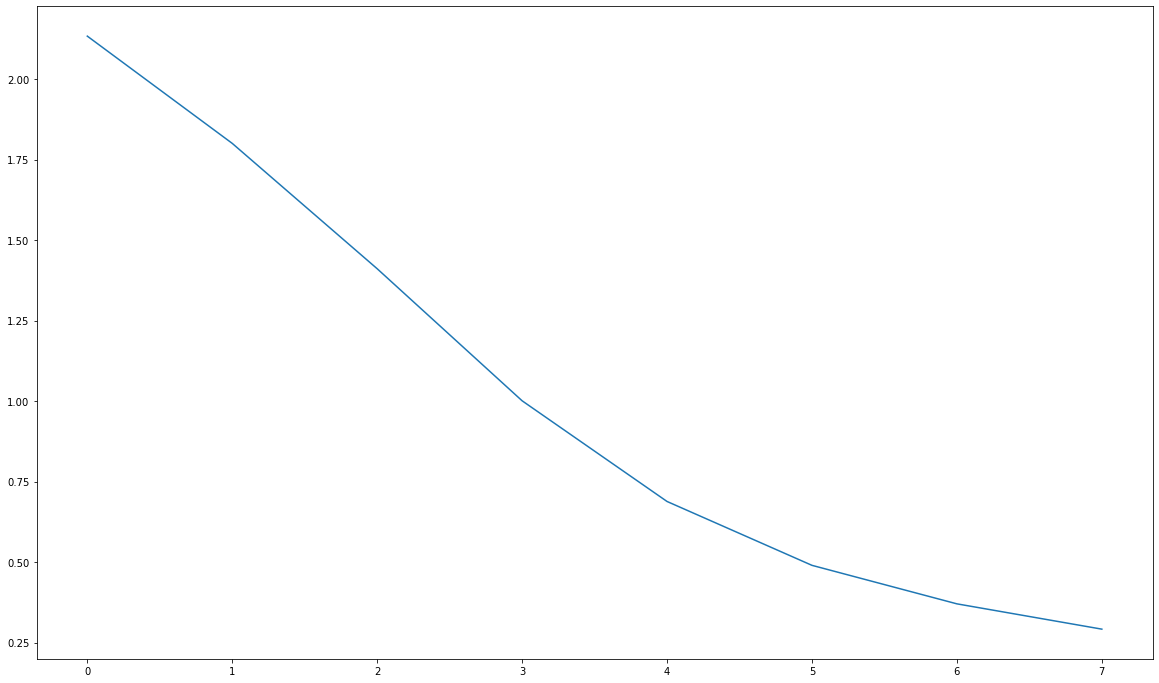

In [17]:
plt.figure(figsize= (20,12))
plt.plot(modfit.history['loss'])

In [ ]:
#print(X_test)
#import copy
#from tensorflow import SparseTensor
#TEST= copy.deepcopy(X_test)

In [18]:
y_predicted = model.predict(X_test)
#mse = tf.keras.losses.MeanSquaredError()
#print(mse(y_test, y_predicted).numpy())

In [19]:
#print(classification_report(y_test,y_predicted))

# 375/375 [==============================] - 1s 2ms/step - loss: 4.5983 - accuracy: 0.2663 - mae: 8.2150

accuracy = model.evaluate(X_test, y_test, verbose= True)

375/375 [==============================] - 3s 9ms/step - loss: 3.5966 - accuracy: 0.2578 - mae: 8.2150


In [ ]:
#375/375 [==============================] - 6s 12ms/step - loss: 4.4008 - accuracy: 0.2586 - mae: 8.2150 Sans TFIDF... Peu de changement !

## lkqhmlkfqsh 

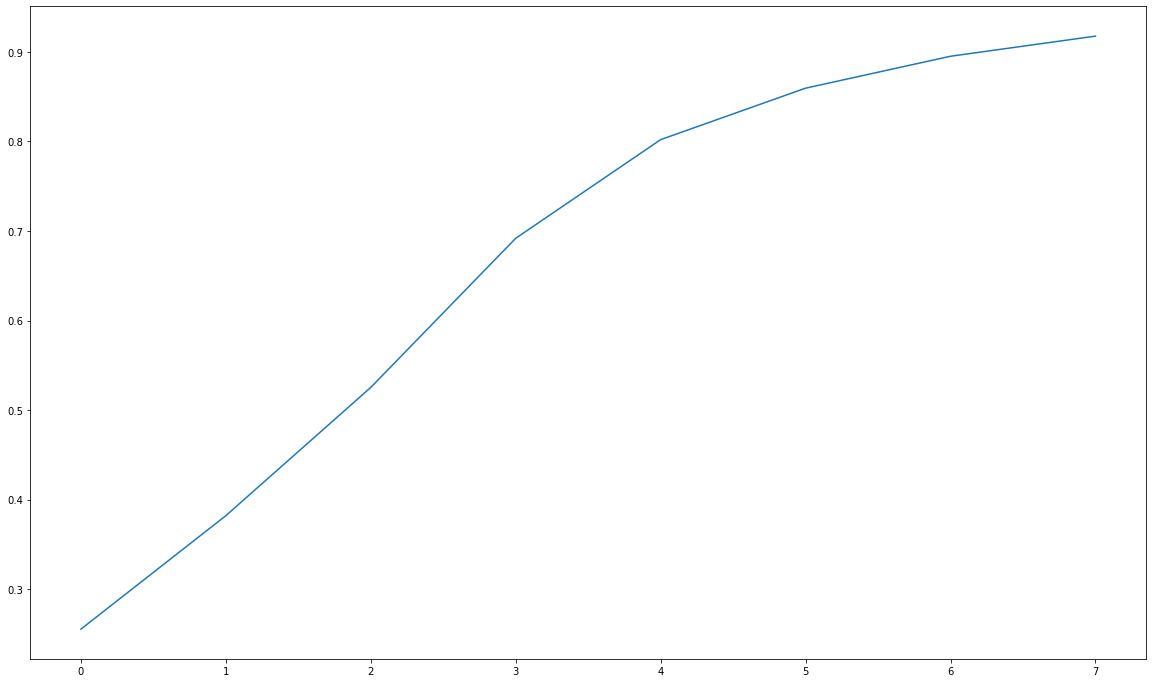

In [20]:
plt.figure(figsize= (20,12))
plt.plot(modfit.history['accuracy'])

In [21]:
#import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


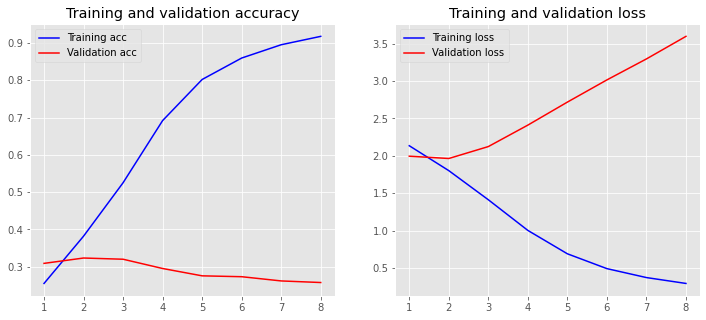

In [22]:
plot_history(modfit)

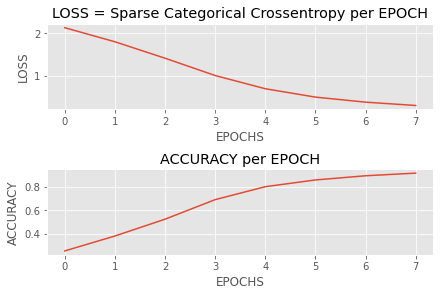

In [23]:
# Code d'Olivier
#LOSS + ACCURACY per EPOCHS

# Create two subplots and unpack the output array immediately
fig, ax = plt.subplots(2, 1, constrained_layout=True)

ax[0].set_title('LOSS = Sparse Categorical Crossentropy per EPOCH')
ax[0].set_xlabel('EPOCHS')
ax[0].set_ylabel('LOSS')
ax[0].plot(modfit.history['loss'])
ax[0].grid(True)

ax[1].set_title('ACCURACY per EPOCH')
ax[1].set_xlabel('EPOCHS')
ax[1].set_ylabel('ACCURACY')
ax[1].plot(modfit.history['accuracy'])
ax[1].grid(True)

plt.show()